In [22]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.training import train_state
import matplotlib.pyplot as plt

import os
import gzip
import numpy as np
import requests
from tqdm import tqdm

data_dir = "./data"
device = jax.devices('cpu')[0]
print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : TFRT_CPU_0


In [32]:
class MNISTDataset:
    def __init__(self, root="./data", train=True, download=True, transform=None):
        self.root = os.path.join(root, "MNIST", "raw")
        self.train = train
        self.transform = transform

        self.download_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

        self.files = {
            "train_images": "train-images-idx3-ubyte.gz",
            "train_labels": "train-labels-idx1-ubyte.gz",
            "test_images": "t10k-images-idx3-ubyte.gz",
            "test_labels": "t10k-labels-idx1-ubyte.gz",
        }

        if download:
            self._download_if_needed()

        img_file = self.files["train_images" if train else "test_images"]
        lbl_file = self.files["train_labels" if train else "test_labels"]

        self.images = self._load_images(os.path.join(self.root, img_file))
        self.labels = self._load_labels(os.path.join(self.root, lbl_file))

    def _download_if_needed(self):
        os.makedirs(self.root, exist_ok=True)
        for filename in self.files.values():
            path = os.path.join(self.root, filename)
            if not os.path.exists(path):
                print(f"Downloading {filename}...")
                self._download_file(self.download_url + filename, path)

    def _download_file(self, url, path):
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            with open(path, 'wb') as f, tqdm(
                    desc=path,
                    total=total_size,
                    unit='B',
                    unit_scale=True,
                    unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(chunk_size=1024):
                    f.write(data)
                    bar.update(len(data))
        else:
            print(f"Failed to download {url}. Status code: {response.status_code}")

    def _load_images(self, path):
        with gzip.open(path, 'rb') as f:
            f.read(16)
            data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(-1, 28, 28)

    def _load_labels(self, path):
        with gzip.open(path, 'rb') as f:
            f.read(8)
            return np.frombuffer(f.read(), dtype=np.uint8)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]


class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True, drop_last=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.indices = np.arange(len(dataset))

    def __iter__(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

        batch = []
        for idx in self.indices:
            batch.append(self.dataset[idx])
            if len(batch) == self.batch_size:
                images, labels = zip(*batch)
                yield np.stack(images), np.array(labels)
                batch = []

        if batch and not self.drop_last:
            images, labels = zip(*batch)
            yield np.stack(images), np.array(labels)

    def __len__(self):
        return len(self.indices)

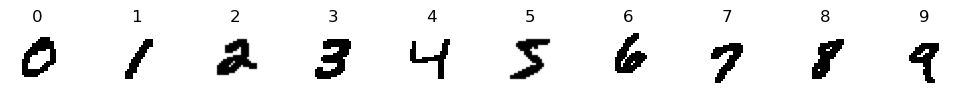

In [33]:
def print_samples(samples, elements_per_row=10, fig_width=10, cmap="binary"):
    num_digits = len(samples)
    num_rows = (num_digits + elements_per_row - 1) // elements_per_row

    plt.figure(figsize=(fig_width, fig_width / elements_per_row * num_rows))
    for idx, (label, image) in enumerate(samples):
        plt.subplot(num_rows, elements_per_row, idx + 1)
        plt.imshow(image.squeeze(), cmap=cmap)
        plt.title(label, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


transform = lambda x: (x > 0.5).astype(jnp.float32)

train_dataset = MNISTDataset(root=data_dir, train=True, download=True, transform=transform)

sample_list = [(label, next(image for image, lbl in train_dataset if lbl == label)) for label in range(10)]
print_samples(sample_list)